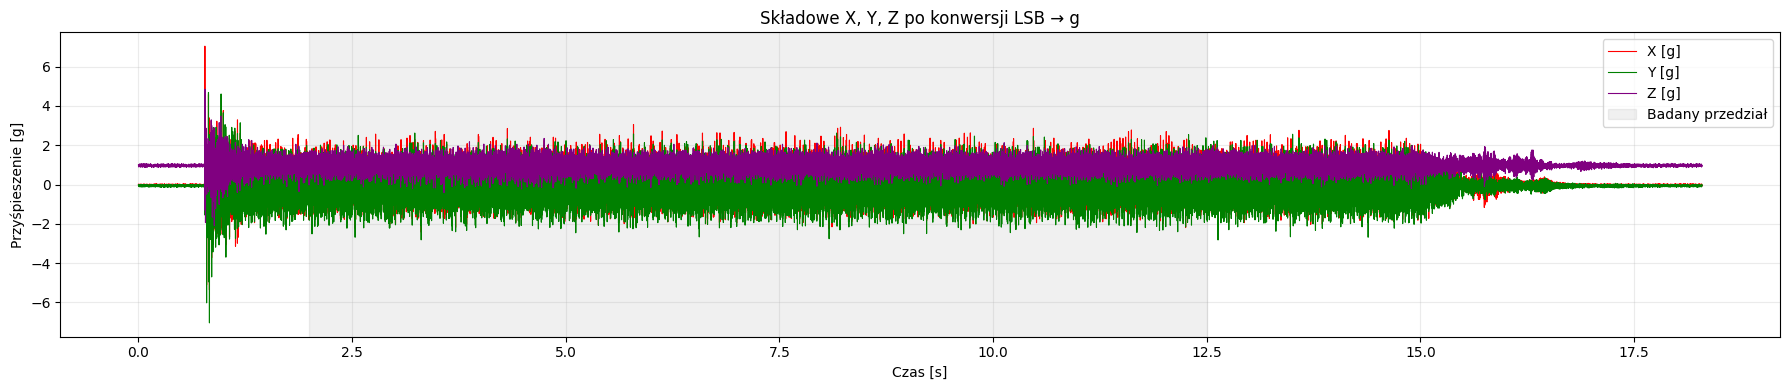

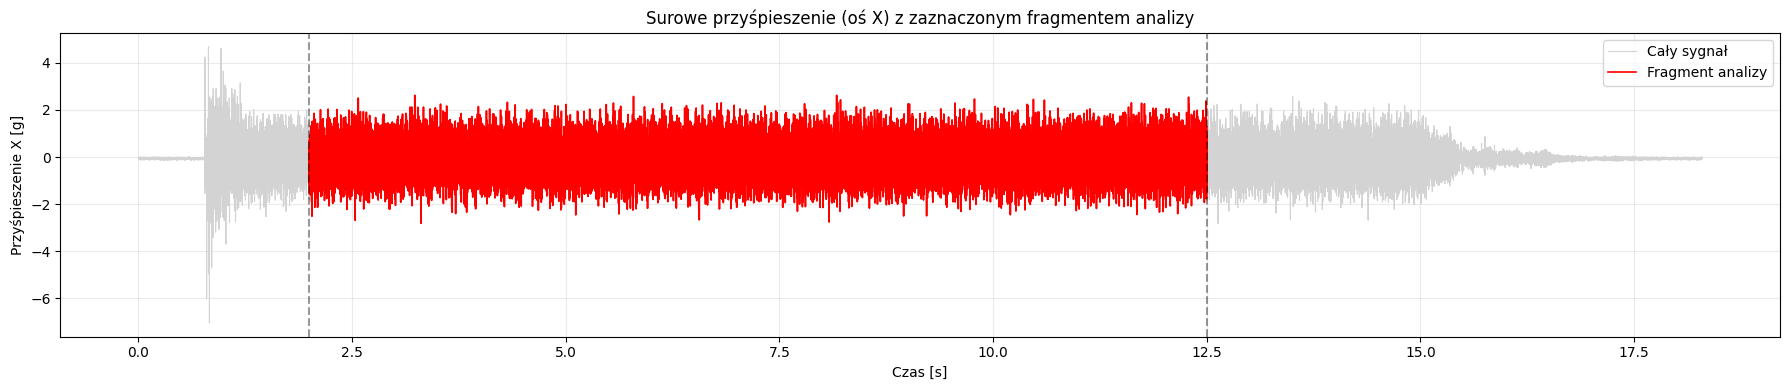

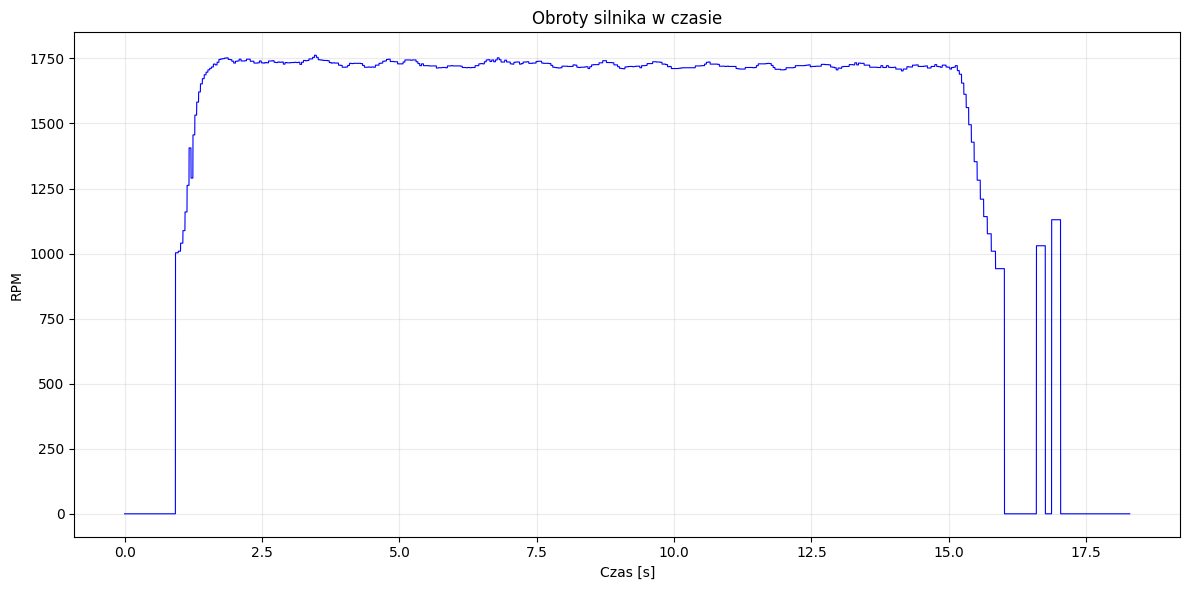

[INFO] Fragment: 2.00-12.50s -> 16801 próbek (~10.50s)


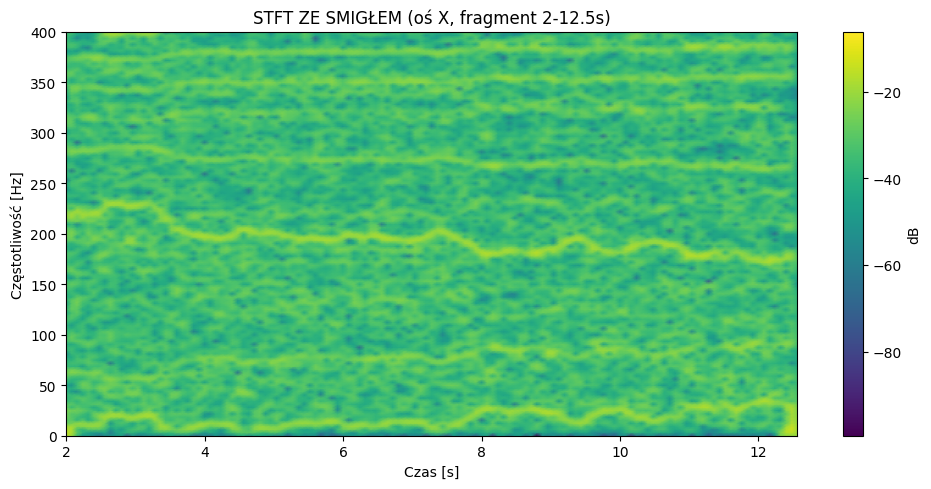

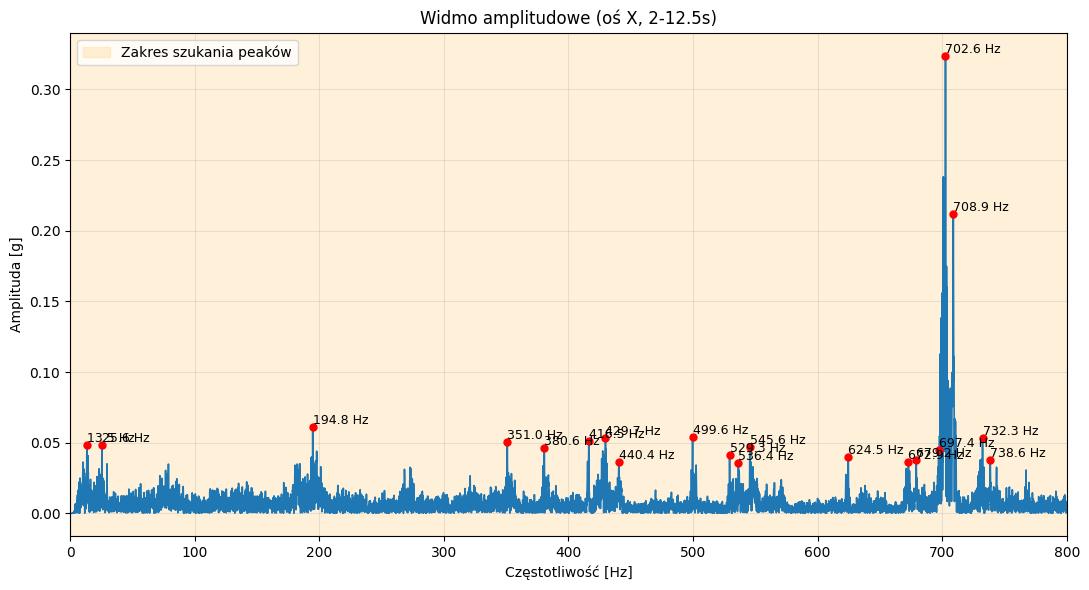


=== TOP PEAKI W ZAKRESIE fmin-fmax I POWYŻEJ MIN. AMPLITUDY ===
fmin = 0.00 Hz, fmax = 800.00 Hz, min_amp = 0.0005
 702.62 Hz     0.3238 g
 708.89 Hz     0.2120 g
 194.76 Hz     0.0614 g
 499.63 Hz     0.0540 g
 732.34 Hz     0.0534 g
 429.72 Hz     0.0530 g
 416.49 Hz     0.0509 g
 350.96 Hz     0.0503 g
  25.60 Hz     0.0482 g
  13.49 Hz     0.0481 g
 545.56 Hz     0.0467 g
 380.59 Hz     0.0462 g
 697.41 Hz     0.0451 g
 529.34 Hz     0.0410 g
 624.46 Hz     0.0399 g
 679.19 Hz     0.0377 g
 738.57 Hz     0.0376 g
 672.89 Hz     0.0366 g
 440.42 Hz     0.0365 g
 536.40 Hz     0.0356 g


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

fs = 1600
lsb_to_g = 0.0039
t_start, t_end = 2, 12.5

fmax_plot = fs/2
n_fft_pad_factor = 8
peak_prominence = 0.00001
peak_distance_hz = 5.0
num_top_peaks = 20

# minimalna amplituda piku (w [g])
peak_min_amp = 0.0005

# zakres częstotliwości, w którym szukasz peaków (opcjonalnie)
fmin_peaks = 0.0
fmax_peaks = 800.0


#df = pd.read_csv('data/pomiary_20_11_25/kupione_20%_z_1600Hz.csv') 
#df = pd.read_csv('data/pomiary_finalne/fabryczne_smiglo_druga/pwm_50%/2_fabryczne_druga_50%.csv') 
#df = pd.read_csv('data/pomiary_finalne/fabryczne_nieuszkodzone/pwm_20%/3_fabryczne_nieuszkodzone_20%_fs1600.csv') 
df = pd.read_csv('data/pomiary_finalne/fabryczne_uszkodzone/pwm_20%/5_fabryczne_uszkodzone_20%.csv') 
#df = pd.read_csv('data/pomiary_finalne/kupione_2x_śrubki/pwm_25%/3_kupione_2x_śrubki_25%.csv')
# konwersja LSB → g
df['X_g'] = df['X'] * lsb_to_g
df['Y_g'] = df['Y'] * lsb_to_g
df['Z_g'] = df['Z'] * lsb_to_g
df['rpm'] = df['rpm']


t = df['czas [s]'].to_numpy()
x_raw = df['Y_g'].to_numpy()

# wykres składowych X, Y, Z
plt.figure(figsize=(18,4))
plt.plot(t, df['X_g'], label='X [g]', lw=0.8, color='red')
plt.plot(t, df['Y_g'], label='Y [g]', lw=0.8, color='green')
plt.plot(t, df['Z_g'], label='Z [g]', lw=0.8, color='purple')
plt.axvspan(t_start, t_end, color='k', alpha=0.06, label='Badany przedział')
plt.title('Składowe X, Y, Z po konwersji LSB → g')
plt.xlabel('Czas [s]')
plt.ylabel('Przyśpieszenie [g]')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# wykres sygnału z zaznaczonym fragmentem analizy
mask = (t >= t_start) & (t <= t_end)
plt.figure(figsize=(18,4))
plt.plot(t, x_raw, color='lightgray', lw=0.8, label='Cały sygnał')
plt.plot(t[mask], x_raw[mask], color='red', lw=1.2, label='Fragment analizy')
plt.axvline(t_start, color='k', ls='--', alpha=0.4)
plt.axvline(t_end,   color='k', ls='--', alpha=0.4)
plt.title('Surowe przyśpieszenie (oś X) z zaznaczonym fragmentem analizy')
plt.xlabel('Czas [s]')
plt.ylabel('Przyśpieszenie X [g]')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# wykres rpm do czasu
plt.figure(figsize=(12,6))
plt.plot(t, df['rpm'], label='RPM', lw=0.8, color='blue')
plt.title('Obroty silnika w czasie')
plt.xlabel('Czas [s]')
plt.ylabel('RPM')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

t_seg = t[mask]; x_seg = x_raw[mask]
print(f"[INFO] Fragment: {t_start:.2f}-{t_end:.2f}s -> {len(x_seg)} próbek (~{len(x_seg)/fs:.2f}s)")

# Bias + HP
N0 = int(min(len(x_seg), 2 * fs))
x0 = x_seg - np.mean(x_seg[:N0])
b, a = signal.butter(2, 5.0/(fs/2), btype='highpass')
x_hp = signal.filtfilt(b, a, x0)

# STFT
f_stft, tt_stft, Sxx = signal.stft(x_hp, fs=fs, window='hann', nperseg=512, noverlap=384)
plt.figure(figsize=(10,5))
plt.pcolormesh(tt_stft + t_start, f_stft, 20*np.log10(np.abs(Sxx)+1e-12), shading='gouraud')
plt.ylim(0, 400)
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')
plt.title(f'STFT ZE SMIGŁEM (oś X, fragment {t_start}-{t_end}s)')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

# FFT z oknem + zero-padding
w = signal.windows.hann(len(x_hp), sym=False)
CG = np.sum(w)/len(w)
xw = x_hp * w
N = len(xw)
N_fft = int(2**np.ceil(np.log2(N))) * n_fft_pad_factor
X = np.fft.rfft(xw, n=N_fft)
freqs = np.fft.rfftfreq(N_fft, 1/fs)
amp = (2.0/(N*CG))*np.abs(X)
amp[0] /= 2.0

# Detekcja peaków z możliwością ustawienia fmin/fmax + minimalnej amplitudy
def find_peaks_with_freqs(freqs, amp, fmin=None, fmax=None,
                          prominence=0.01, distance_hz=5.0, min_height=None):
    mask_f = np.ones_like(freqs, dtype=bool)
    if fmin is not None:
        mask_f &= (freqs >= fmin)
    if fmax is not None:
        mask_f &= (freqs <= fmax)
    fc = freqs[mask_f]
    ac = amp[mask_f]
    if len(fc) < 2:
        return np.array([], dtype=int), {}, fc, ac
    dfreq = fc[1] - fc[0]
    peaks, props = signal.find_peaks(
        ac,
        prominence=prominence,
        distance=max(1, int(np.round(distance_hz/dfreq))),
        height=min_height
    )
    return peaks, props, fc, ac

peaks, props, fc, ac = find_peaks_with_freqs(
    freqs,
    amp,
    fmin=fmin_peaks,
    fmax=fmax_peaks,
    prominence=peak_prominence,
    distance_hz=peak_distance_hz,
    min_height=peak_min_amp
)

if len(peaks) > 0:
    order = np.argsort(ac[peaks])[::-1]
    top_idx = peaks[order][:num_top_peaks]
    top_freqs = fc[top_idx]
    top_amps  = ac[top_idx]
else:
    top_freqs = np.array([])
    top_amps  = np.array([])

# Wykres FFT
plt.figure(figsize=(11,6))
plt.plot(freqs, amp, lw=1.2)
plt.xlim(0, fmax_plot)
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda [g]')
plt.title(f'Widmo amplitudowe (oś X, {t_start}-{t_end}s)')

# podświetlenie zakresu, w którym szukasz peaków
plt.axvspan(fmin_peaks, fmax_peaks, color='orange', alpha=0.15, label='Zakres szukania peaków')

# piki w zadanym zakresie fmin/fmax
for f, a in zip(top_freqs, top_amps):
    plt.plot([f], [a], 'ro', ms=5)
    plt.text(f, a, f'{f:.1f} Hz', fontsize=9, ha='left', va='bottom')

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== TOP PEAKI W ZAKRESIE fmin-fmax I POWYŻEJ MIN. AMPLITUDY ===")
print(f"fmin = {fmin_peaks:.2f} Hz, fmax = {fmax_peaks:.2f} Hz, min_amp = {peak_min_amp}")
if len(top_freqs) == 0:
    print("Brak peaków spełniających kryteria.")
else:
    for f, a in zip(top_freqs, top_amps):
        print(f"{f:7.2f} Hz   {a:8.4f} g")
